# Imports

In [1]:
import pickle
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms.functional as F

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pickle Files

load the pickle files, audio_data is a list of arrays, where the arrays are of different shapes

In [2]:
def trim_array(arr):
    if np.all(arr == 0):  # Check if the array is all zeros
        return arr
    first_non_zero = np.argmax(arr != 0)
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0)
    return arr[first_non_zero:last_non_zero]

In [3]:
allaudios = [] # Creates an empty list
for root, dirs, files in os.walk("train"):
    i=0 
    for file in files:
        if file.endswith(".pkl"):
           audio = file
           openaudios = open(os.getcwd() + "/train/" + audio, 'rb')
           loadedaudios = pickle.load(openaudios)
           
           allaudios.append(loadedaudios)
           i+=1
           if i==2000:
               break

audio_data = []
valence = []
audio_lengths = []
for audio in allaudios:
    # Get Rid of front and end trailing zeros
    audio_trimmed = trim_array(audio['audio_data'])
    audio_data.append(audio_trimmed)

    audio_length = len(audio_trimmed)
    audio_lengths.append(audio_length)
    valence.append(audio['valence'])

# Data Investigation

In [4]:
print(len(audio_data))
print(len(valence))

2000
2000


In [5]:
mean = np.mean(np.concatenate(audio_data))
mom = np.mean([np.mean(arr) for arr in audio_data]) # mean of means

std = np.std(np.concatenate(audio_data))
average_std = np.mean([np.std(arr) for arr in audio_data])

print(f'Concatenated mean: {mean} \nMean of Means:{mom} \nConcatenated std: {std} \nAverage std per array {average_std}')


Concatenated mean: -1.9027120288228616e-05 
Mean of Means:-1.561821045470424e-05 
Concatenated std: 0.09038412570953369 
Average std per array 0.07159483432769775


does not max sense to go off max better to take mean or median 

Mean Length: 36415.1595
Median Length: 32832.0
Standard Deviation: 20736.029745519267
Minimum Length: 7520
Maximum Length: 169056


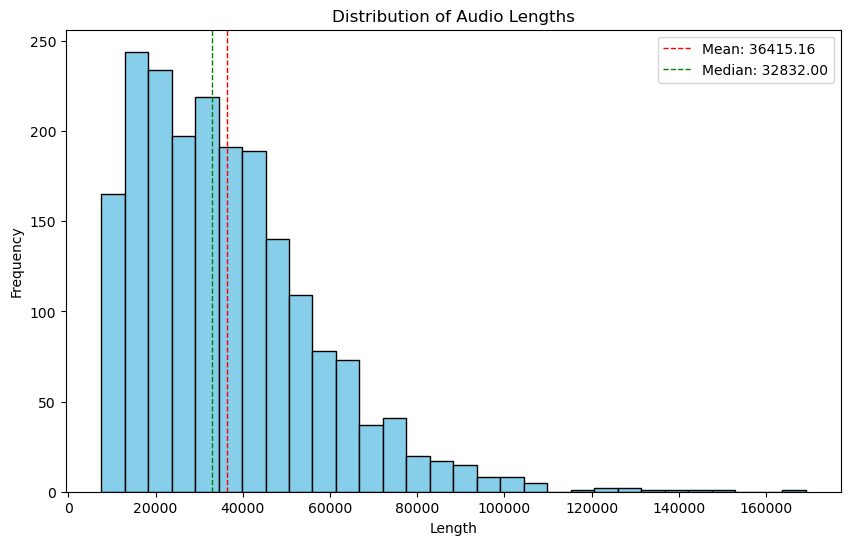

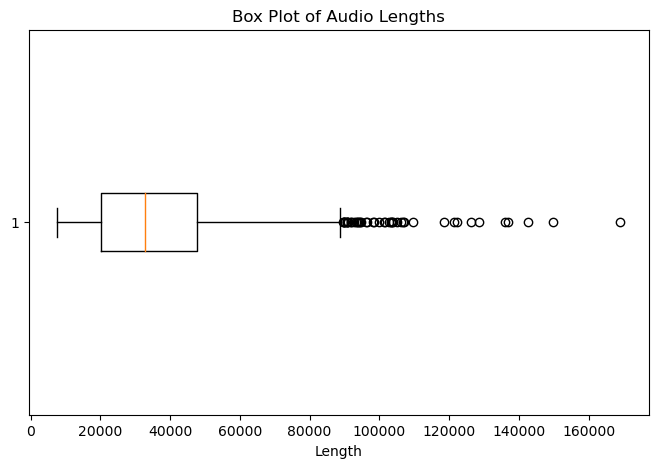

In [6]:
mean_length = np.mean(audio_lengths)
median_length = np.median(audio_lengths)
std_dev = np.std(audio_lengths)
min_length = np.min(audio_lengths)
max_length = np.max(audio_lengths)

print("Mean Length:", mean_length)
print("Median Length:", median_length)
print("Standard Deviation:", std_dev)
print("Minimum Length:", min_length)
print("Maximum Length:", max_length)

# Histogram of the lengths
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.legend()
plt.show()

# Optional: Box Plot
plt.figure(figsize=(8, 5))
plt.boxplot(audio_lengths, vert=False)
plt.title('Box Plot of Audio Lengths')
plt.xlabel('Length')
plt.show()

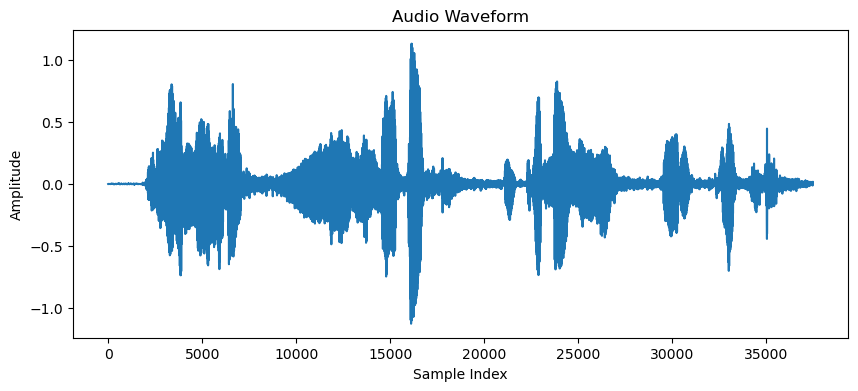

In [7]:
plt.figure(figsize=(10, 4))  # Specify the figure size
plt.plot(audio_data[10])    # Plot the audio data
plt.title('Audio Waveform')  # Set the title of the plot
plt.xlabel('Sample Index')   # Label for the x-axis
plt.ylabel('Amplitude')      # Label for the y-axis
plt.show()  

# Pad Trunc

https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

In [8]:
def pad_trunc_audio(audio_data, target_length = int(np.percentile(audio_lengths, 95))):
    standardized_data = []
    for data in audio_data:
        if len(data) < target_length:
            padded_data = np.pad(data, (0, target_length - len(data)), 'constant', constant_values=(0, 0))
            standardized_data.append(padded_data)
        elif len(data) > target_length:
            truncated_data = data[:target_length]
            standardized_data.append(truncated_data)
        else:
            standardized_data.append(data)
    return standardized_data


In [9]:
standardized_audios = pad_trunc_audio(audio_data)


# Train Test Data for Model

In [10]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
size_train = int(round(len(standardized_audios) * 0.8))
X_train = standardized_audios[:size_train]
X_test = standardized_audios[size_train:]
y_train = valence[:size_train]
y_test = valence[size_train:]

batch_size = 64

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.



# Stenograph

Nina's

In [12]:
class Construct_mel_spectrogram(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        with torch.no_grad():
            # make a spectrogram using short-time Fourier transform
            spectrogram = librosa.stft(x)

            # separate the spectrogram into the magnitude and phase components
            spectrogram_mag_and_phase, _ = librosa.magphase(spectrogram)

            # compute the mel-scaled spectrogram - mel-scale takes into account how humans perceive frequencies
            mel_scale_spectrogram = librosa.feature.melspectrogram(S=spectrogram_mag_and_phase, sr=8000)

            # covert amplitude spectrogram to a dB-scaled spectrogram
            mel_spectrogram = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)
            
            
        return torch.from_numpy(mel_spectrogram)
    
mel_spectrogram = Construct_mel_spectrogram()



Chat:

When working with libraries like librosa that are oriented towards processing individual audio files, any batch processing must be manually managed by looping over each item in the batch.

In [13]:
class ConstructMelSpectrogram_chat(nn.Module):
    def __init__(self, sample_rate=8000):
        super().__init__()
        self.sample_rate = sample_rate
    
    def forward(self, x):
        # Ensure x is a numpy array on CPU
        x = x.numpy() if not x.is_cuda else x.cpu().numpy()

        # Initialize an empty list to collect mel spectrograms
        batch_mel_spectrograms = []

        with torch.no_grad():
            for solo_audio in x:
                # Compute the spectrogram using STFT
                spectrogram = librosa.stft(solo_audio)
                
                # Separate the spectrogram into magnitude and phase components
                magnitude, _ = librosa.magphase(spectrogram)
                
                # Compute the mel-scale spectrogram
                mel_scale_spectrogram = librosa.feature.melspectrogram(S=magnitude**2, sr=self.sample_rate)
                mel_scale_spectrogram = librosa.feature.melspectrogram(S=magnitude, sr=self.sample_rate) # why not squared Nina??
                
                # Convert the mel-scale spectrogram to dB-scale
                mel_spectrogram = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)
                
                # Append the processed spectrogram to the list
                batch_mel_spectrograms.append(mel_spectrogram)
        
        # Convert list of numpy arrays to a single numpy array
        batch_mel_spectrograms = np.stack(batch_mel_spectrograms)

        # Convert numpy array back to PyTorch tensor
        return torch.from_numpy(batch_mel_spectrograms)

# Usage
mel_spectrogram_module = ConstructMelSpectrogram_chat()

tensor([-0.0008, -0.0010, -0.0003,  ...,  0.0000,  0.0000,  0.0000])
torch.Size([64, 128, 147])
tensor([[69.7102, 73.7773, 74.6115,  ..., 51.2242, 51.2242, 51.2242],
        [67.7351, 70.5375, 69.0215,  ..., 51.2242, 51.2242, 51.2242],
        [72.3016, 72.7784, 68.7852,  ..., 51.2242, 51.2242, 51.2242],
        ...,
        [51.2242, 51.2242, 51.2242,  ..., 51.2242, 51.2242, 51.2242],
        [51.2242, 51.2242, 51.2242,  ..., 51.2242, 51.2242, 51.2242],
        [51.2242, 51.2242, 51.2242,  ..., 51.2242, 51.2242, 51.2242]])
tensor([[69.7102, 73.7773, 74.6115,  ..., 34.6650, 34.6650, 34.6650],
        [67.7351, 70.5375, 69.0215,  ..., 34.6650, 34.6650, 34.6650],
        [72.3016, 72.7784, 68.7852,  ..., 34.6650, 34.6650, 34.6650],
        ...,
        [34.6650, 34.6650, 34.6650,  ..., 34.6650, 34.6650, 34.6650],
        [34.6650, 34.6650, 34.6650,  ..., 34.6650, 34.6650, 34.6650],
        [34.6650, 34.6650, 34.6650,  ..., 34.6650, 34.6650, 34.6650]])


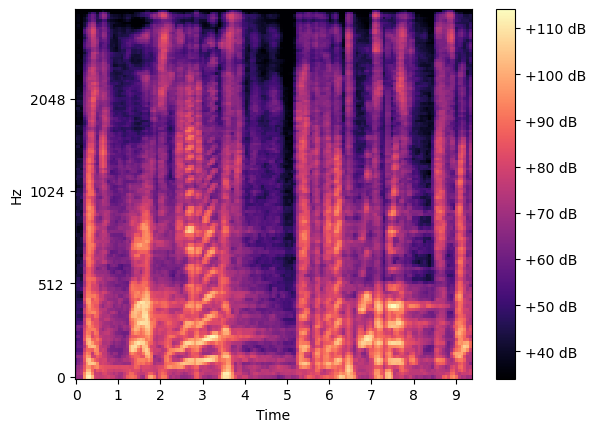

In [14]:
for audio, labels in train_dataloader:
        print(audio[0])
        spectorgrams = mel_spectrogram(audio.numpy())
        print(spectorgrams.shape)
        print(spectorgrams[0])
        # #plot the results
        # librosa.display.specshow(spectorgrams.numpy()[2], sr=8000, x_axis='time', y_axis='mel')
        # plt.colorbar(format='%+2.0f dB')
        # plt.plot()

        # Code CoPilot Approach
        spectorgrams2 = mel_spectrogram_module(audio) # [batch, 128,145]
        print(spectorgrams2[0])
        #plot the results
        librosa.display.specshow(spectorgrams2.numpy()[2], sr=8000, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.plot()
        break
    

# Model Setup

In [15]:
class CNN(nn.Module):
    def __init__(self, pre_proocesses, hidden_sizes, activation_function, linear_layer1_size):

        super(CNN, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function
        self.linear_layer1_size = linear_layer1_size

        self.height = 128
        self.width = 145

        self.layers = nn.ModuleList()

        # # add preprocessing steps
        # for process in pre_proocesses:
        #     self.layers.append(process)

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv2d(1 if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3, padding=1))
            self.height = int(self.height / 1)
            self.width = int(self.width / 1)
            self.layers.append(nn.BatchNorm2d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool2d(kernel_size=2))
            self.height = int(self.height / 2)
            self.width = int(self.width / 2)
            self.layers.append(self.activation_function())


        # self.layers.append(nn.AdaptiveAvgPool1d(1))
        self.layers.append(nn.Flatten()) 
        self.layers.append(nn.Linear(in_features=(self.hidden_sizes[-1] * self.height * self.width), out_features=self.linear_layer1_size, bias=True))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.linear_layer1_size, out_features=1, bias=True))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        x = 1 + 4 * torch.sigmoid(x) #(range from 1 to 5)
        return x

In [16]:
cnn_model = CNN(pre_proocesses=[], hidden_sizes=[32,64], activation_function=nn.ReLU, linear_layer1_size=500).to(device)
print(cnn_model)

CNN(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=73728, out_features=500, bias=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=500, out_features=1, bias=True)
  )
)


In [17]:
criterion = nn.MSELoss()

for audio, valence in train_dataloader:
        print(valence[0])
        spectorgrams = mel_spectrogram_module(audio) # [batch, 128,145]
        # print(spectorgrams[0])
        # #plot the results
        # librosa.display.specshow(spectorgrams.numpy()[40], sr=8000, x_axis='time', y_axis='mel')
        # plt.colorbar(format='%+2.0f dB')
        

        spectorgrams = spectorgrams.unsqueeze(1) # [batch, channel=1, 128,145]
        outputs = cnn_model(spectorgrams)
        outputs = outputs.squeeze()  # Reshape the output to match target
        loss = criterion(outputs, valence)
        print(loss)
        print(outputs.shape)
        print(valence.shape)
        print()
        
        print(outputs)
        break

tensor(3., dtype=torch.float64)
tensor(1.2028, dtype=torch.float64, grad_fn=<MseLossBackward0>)
torch.Size([64])
torch.Size([64])

tensor([2.6847, 2.5400, 2.8544, 2.5568, 2.9070, 2.9395, 2.6303, 2.6504, 3.1115,
        2.5079, 2.5047, 3.3066, 2.8362, 3.5941, 2.4934, 2.7463, 2.2972, 2.6671,
        1.8971, 3.2647, 2.9414, 2.6399, 3.2972, 2.9582, 3.2042, 3.1423, 2.6624,
        2.2193, 2.7012, 2.8245, 2.1929, 3.0180, 2.0992, 2.5719, 2.6071, 3.1129,
        2.2780, 2.3785, 2.2017, 2.8538, 2.1776, 2.5327, 2.3089, 2.8135, 2.8582,
        3.0537, 3.1687, 2.9432, 2.7880, 2.4689, 3.0314, 2.4147, 2.4392, 2.2046,
        2.7412, 2.8331, 2.4881, 2.6271, 3.0296, 2.6275, 2.5640, 2.3871, 2.7046,
        2.3789], grad_fn=<SqueezeBackward0>)


In [18]:
def calculate_metrics(actual, predicted):

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R^2)": r2
    }


In [19]:
def loss_plot(train_loss, validation_loss):
    epochs = range(1, len(train_loss) + 1) # start at 1 instead of 0
    # Plotting the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [20]:
def train_model(net, optimizer, train_loader, val_loader, epochs):
    # Define the loss function
    criterion = nn.MSELoss()
    # Define the optimizer

    train_loss_lst = []
    val_loss_lst = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        # Iterate over training batches
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for audio, valence in train_loader:
                optimizer.zero_grad()  # Reset gradients
                valence = valence.float() # was double 

                spectorgrams = mel_spectrogram_module(audio) # [batch, 128,145]
                spectorgrams = spectorgrams.unsqueeze(1) # [batch, channel=1, 128,145]
                spectorgrams, valence = spectorgrams.to(device), valence.to(device)

                outputs = net(spectorgrams)
                outputs = outputs.squeeze()  # Reshape the output to match target
                loss = criterion(outputs, valence)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                pbar.set_postfix({'loss': running_loss / (len(pbar) + 1)})  # Display average loss
                pbar.update(1)  # Update the progress bar
        train_loss = running_loss / len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        net.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for audio, valence in val_loader:
                valence = valence.float() # was double

                spectorgrams = mel_spectrogram_module(audio) # [batch, 128,145]
                spectorgrams = spectorgrams.unsqueeze(1) # [batch, channel=1, 128,145]
                spectorgrams, valence = spectorgrams.to(device), valence.to(device)
                outputs = net(spectorgrams)
                outputs = outputs.squeeze()  # Reshape the output to match target
                val_loss = criterion(outputs, valence)
                val_running_loss += val_loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_loss_lst.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    #display loss graph
    loss_plot(train_loss_lst, val_loss_lst)
    print("Training for CNN is finished.")

    return val_loss_lst

Epoch 1/10: 100%|██████████| 25/25 [00:43<00:00,  1.73s/batch, loss=4.35] 


Epoch 1/10, Train Loss: 4.5222, Val Loss: 5.0498


Epoch 2/10: 100%|██████████| 25/25 [01:01<00:00,  2.45s/batch, loss=4.46]


Epoch 2/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 3/10: 100%|██████████| 25/25 [01:05<00:00,  2.60s/batch, loss=4.46]


Epoch 3/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 4/10: 100%|██████████| 25/25 [01:05<00:00,  2.64s/batch, loss=4.46]


Epoch 4/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 5/10: 100%|██████████| 25/25 [01:08<00:00,  2.73s/batch, loss=4.46]


Epoch 5/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 6/10: 100%|██████████| 25/25 [01:20<00:00,  3.23s/batch, loss=4.46]


Epoch 6/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 7/10: 100%|██████████| 25/25 [01:29<00:00,  3.56s/batch, loss=4.46]


Epoch 7/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 8/10: 100%|██████████| 25/25 [01:58<00:00,  4.75s/batch, loss=4.46]


Epoch 8/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 9/10: 100%|██████████| 25/25 [01:34<00:00,  3.76s/batch, loss=4.46]


Epoch 9/10, Train Loss: 4.6370, Val Loss: 5.0498


Epoch 10/10: 100%|██████████| 25/25 [01:41<00:00,  4.04s/batch, loss=4.46]


Epoch 10/10, Train Loss: 4.6370, Val Loss: 5.0498


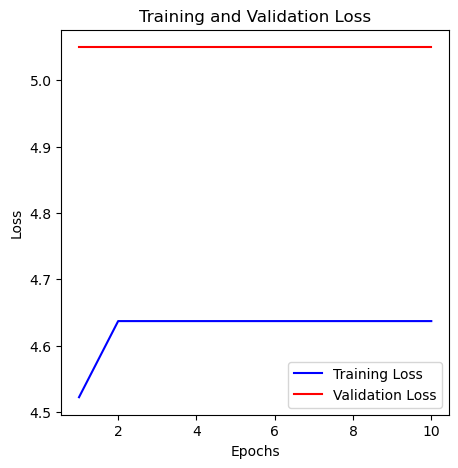

Training for CNN is finished.


In [21]:
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
val_loss_lst = train_model(cnn_model, optimizer, train_dataloader, test_dataloader, 10)

# Grid Search For Hyperparameters

In [ ]:
def plot_search(results, x_str, y_str, res_str, scale=False):

    # Assuming coarse_results is a list of dictionaries with 'lr', 'hidden_size', 'val_loss', and 'accuracy'
    # Extract relevant information for the heatmap
    lr_values = [result[x_str] for result in results]
    hidden_size_values = [result[y_str] for result in results]
    val_loss_values = [result[res_str] for result in results]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.scatter(lr_values, hidden_size_values, c=val_loss_values, cmap='RdYlGn', marker='o', s=100)
    plt.colorbar(heatmap, label=res_str)
    if scale:
        plt.xscale('log')  # Use a logarithmic scale for learning rates if appropriate

    # Set labels and title
    plt.xlabel(x_str)
    plt.ylabel(y_str)
    plt.title('Hyperparameter Search')
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
def hyper_train_setup(hidden_sizes, learning_rate, num_epochs):
  # Create the model
    model = CNN(pre_proocesses=[], hidden_sizes=hidden_sizes, activation_function=nn.ReLU, linear_layer1_size=500).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    ## Train the model
    eval_loss = train_model(cnn_model, optimizer, train_dataloader, test_dataloader, num_epochs)
    return eval_loss[-1] # last epoch loss

In [ ]:
import random 
import math

# Coarse Random Search
coarse_trials = 7
num_epochs = 15
coarse_results = []


for i in range(coarse_trials):
    
    #### COMPLETE THE CODE ####
    lr = 10**random.uniform(math.log10(0.001), math.log10(0.1))
    hidden_size = int(2**random.uniform(4, 6))
    hidden_sizes = [hidden_size]
    val_loss = hyper_train_setup(hidden_sizes, lr, num_epochs)

    coarse_results.append({'lr': lr, 'hidden_size': hidden_size, 'loss': val_loss})

    print(f"{i+1}. Learning rate: {lr:.4} and hidden sizes: {hidden_sizes}")
    print(f"\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from coarse search
best_coarse_params = min(coarse_results, key=lambda x: x['loss'])
print(f"Best parameters found:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden size: {best_coarse_params['hidden_size']}\n - Validation loss: {best_coarse_params['loss']:.5}%")

plot_search(coarse_results)

In [ ]:
fine_trials = 5
fine_results = []

for _ in range(fine_trials):
    lr = 2**random.uniform(np.log2(0.5 * best_coarse_params['lr']), np.log2(1.5 * best_coarse_params['lr']))
    hidden_size = random.randint(int(0.8 * best_coarse_params['hidden_size']), int(1.2 * best_coarse_params['hidden_size']) + 1) # not inclusive on the end

    hidden_sizes = [hidden_size]
    val_loss = hyper_train_setup(hidden_sizes, lr, num_epochs)

    fine_results.append({'lr': lr, 'hidden_size': hidden_size, 'loss': val_loss})

    print(f"Learning rate: {lr:.4} and hidden sizes: {hidden_sizes}")
    print(f"\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from fine search
best_fine_params = min(fine_results, key=lambda x: x['loss'])

print(f"Best parameters found with coarse search:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden size: {best_coarse_params['hidden_size']}\n - Validation loss: {best_coarse_params['loss']:.5}%")
print(f"Best parameters found with fine search:\n - Learning rate: {best_fine_params['lr']:.5}\n - Hidden size: {best_fine_params['hidden_size']}\n - Validation loss: {best_fine_params['loss']:.5}%")
plot_search(coarse_results + fine_results)

# Last Year

In [ ]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 6

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)